In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from skimage import io
from wordcloud import WordCloud, STOPWORDS
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import time

In [101]:
data=pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

print('Shape of dataset:', data.shape)
data.columns = data.columns.str.strip()
print('Columns of dataset: ', data.columns.values)

Shape of dataset: (225745, 85)
Columns of dataset:  ['Flow ID' 'Source IP' 'Source Port' 'Destination IP' 'Destination Port'
 'Protocol' 'Timestamp' 'Flow Duration' 'Total Fwd Packets'
 'Total Backward Packets' 'Total Length of Fwd Packets'
 'Total Length of Bwd Packets' 'Fwd Packet Length Max'
 'Fwd Packet Length Min' 'Fwd Packet Length Mean' 'Fwd Packet Length Std'
 'Bwd Packet Length Max' 'Bwd Packet Length Min' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Flow Bytes/s' 'Flow Packets/s' 'Flow IAT Mean'
 'Flow IAT Std' 'Flow IAT Max' 'Flow IAT Min' 'Fwd IAT Total'
 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max' 'Fwd IAT Min' 'Bwd IAT Total'
 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max' 'Bwd IAT Min' 'Fwd PSH Flags'
 'Bwd PSH Flags' 'Fwd URG Flags' 'Bwd URG Flags' 'Fwd Header Length'
 'Bwd Header Length' 'Fwd Packets/s' 'Bwd Packets/s' 'Min Packet Length'
 'Max Packet Length' 'Packet Length Mean' 'Packet Length Std'
 'Packet Length Variance' 'FIN Flag Count' 'SYN Flag Count'
 'RST Fla

In [102]:
print('Gaps or infinities per columns:')
numeric_cols = data.select_dtypes(include=[np.number])
missing = data.isnull().sum()
inf = np.isinf(numeric_cols).sum()

print(missing[missing>0])
print(inf[inf>0])

Gaps or infinities per columns:
Flow Bytes/s    4
dtype: int64
Flow Bytes/s      30
Flow Packets/s    34
dtype: int64


In [103]:
data = data.replace([np.inf, -np.inf], np.nan)

for col in ['Flow Bytes/s', 'Flow Packets/s']:
    data[col] = data[col].fillna(data[col].median())
    
print(data.isnull().sum().sum())

0


In [104]:
target_col = 'Label'
data[target_col].unique()

array(['BENIGN', 'DDoS'], dtype=object)

In [105]:
data[target_col] = data[target_col].factorize()[0]
data[target_col][:100000:10000]

0        0
10000    0
20000    1
30000    1
40000    0
50000    0
60000    0
70000    0
80000    1
90000    1
Name: Label, dtype: int64

In [106]:
features = data.select_dtypes(include=[np.number]).columns.tolist()
X_cols = [c for c in features if c != target_col]

df_small = data[X_cols + [target_col]].copy()
min_class_size = 10000
balanced_df = (
    df_small.groupby(target_col, group_keys=False)
    .sample(n=min_class_size, random_state=42)
)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X = balanced_df[X_cols]
y = balanced_df[target_col]

print('Feature :', features)
print('X :', X.shape)
print('y :',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('X_train :', X_train.shape)
print('y_train :',y_train.shape)
print('X_test :', X_test.shape)
print('y_test :',y_test.shape)

Feature : ['Source Port', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Coun

In [107]:
def evaluate_model(clf, X_tr, X_te, y_tr, y_te, model_name='model'):
    start_fit = time.time()
    clf.fit(X_tr, y_tr)
    end_fit = time.time()
    
    start_pred = time.time()
    y_pred = clf.predict(X_te)
    end_pred = time.time()
    
    print('\n===', model_name, '===')
    print(f"Time to fit: {end_fit - start_fit:.4f} seconds")
    print(f"Time to predict: {end_pred - start_pred:.4f} seconds")
    print('Classification report:')
    print(classification_report(y_te, y_pred))
    
    cm = confusion_matrix(y_te, y_pred)
    print('Confusion matrix:\n', cm)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), fmt='d')
    plt.title(f'Confusion matrix: {model_name}')
    plt.show()
    
    return clf, classification_report(y_te, y_pred, output_dict=True), cm

In [108]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

CV accuracy (mean±std)
Initial KNN (no PCA):      0.9993 ± 0.0006

=== Initial KNN ===
Time to fit: 0.0334 seconds
Time to predict: 0.1746 seconds
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion matrix:
 [[1999    1]
 [   0 2000]]


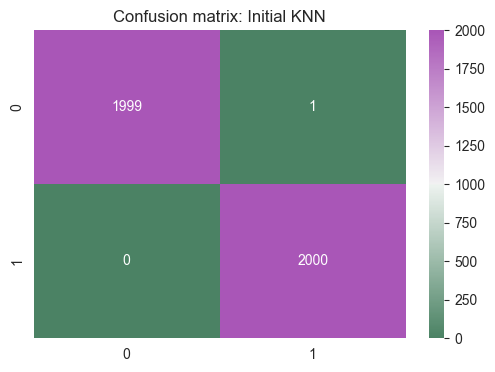

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=3, weights='distance'))]),
 {'0': {'precision': 1.0,
   'recall': 0.9995,
   'f1-score': 0.9997499374843711,
   'support': 2000.0},
  '1': {'precision': 0.9995002498750625,
   'recall': 1.0,
   'f1-score': 0.9997500624843789,
   'support': 2000.0},
  'accuracy': 0.99975,
  'macro avg': {'precision': 0.9997501249375312,
   'recall': 0.99975,
   'f1-score': 0.9997499999843751,
   'support': 4000.0},
  'weighted avg': {'precision': 0.9997501249375311,
   'recall': 0.99975,
   'f1-score': 0.999749999984375,
   'support': 4000.0}},
 array([[1999,    1],
        [   0, 2000]], dtype=int64))

In [109]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=3, weights="distance"))])
cv_knn = cross_val_score(knn_pipe, X_train, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"Initial KNN (no PCA):      {cv_knn.mean():.4f} ± {cv_knn.std():.4f}")

evaluate_model(knn_pipe, X_train, X_test, y_train, y_test, 'Initial KNN')

CV accuracy (mean±std)
KNN with PCA(0.95):     0.9993 ± 0.0005

=== KNN with PCA ===
Time to fit: 0.1335 seconds
Time to predict: 0.1661 seconds
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion matrix:
 [[1999    1]
 [   0 2000]]


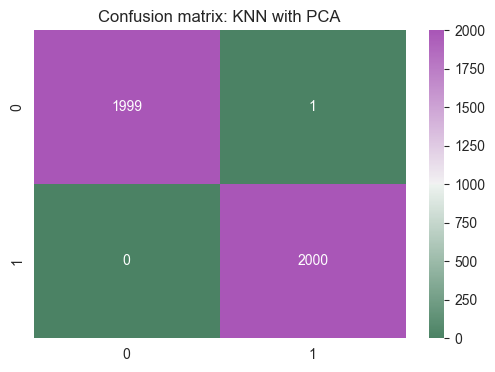

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('pca',
                  PCA(n_components=0.95, random_state=42, svd_solver='full')),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=3, weights='distance'))]),
 {'0': {'precision': 1.0,
   'recall': 0.9995,
   'f1-score': 0.9997499374843711,
   'support': 2000.0},
  '1': {'precision': 0.9995002498750625,
   'recall': 1.0,
   'f1-score': 0.9997500624843789,
   'support': 2000.0},
  'accuracy': 0.99975,
  'macro avg': {'precision': 0.9997501249375312,
   'recall': 0.99975,
   'f1-score': 0.9997499999843751,
   'support': 4000.0},
  'weighted avg': {'precision': 0.9997501249375311,
   'recall': 0.99975,
   'f1-score': 0.999749999984375,
   'support': 4000.0}},
 array([[1999,    1],
        [   0, 2000]], dtype=int64))

In [110]:
knn_pipe_pca = Pipeline([('scaler', StandardScaler()), 
                     ('pca', PCA(n_components=0.95,svd_solver='full', random_state=42)),('knn', KNeighborsClassifier(n_neighbors=3, weights="distance"))])

cv_pca_knn = cross_val_score(knn_pipe_pca, X_train, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"KNN with PCA(0.95):     {cv_pca_knn.mean():.4f} ± {cv_pca_knn.std():.4f}")

evaluate_model(knn_pipe_pca, X_train, X_test, y_train, y_test, 'KNN with PCA')

CV accuracy (mean±std)
Initial SVM (no PCA):     0.9866 ± 0.0025

=== Initial SVM ===
Time to fit: 6.5634 seconds
Time to predict: 0.2744 seconds
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2000
           1       0.98      1.00      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

Confusion matrix:
 [[1957   43]
 [   2 1998]]


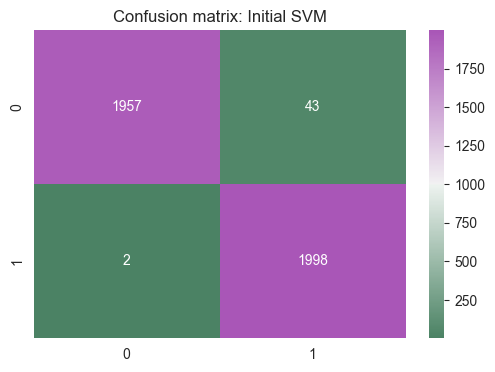

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('svm', SVC(probability=True, random_state=42))]),
 {'0': {'precision': 0.9989790709545686,
   'recall': 0.9785,
   'f1-score': 0.9886334933063905,
   'support': 2000.0},
  '1': {'precision': 0.9789318961293484,
   'recall': 0.999,
   'f1-score': 0.9888641425389755,
   'support': 2000.0},
  'accuracy': 0.98875,
  'macro avg': {'precision': 0.9889554835419585,
   'recall': 0.98875,
   'f1-score': 0.988748817922683,
   'support': 4000.0},
  'weighted avg': {'precision': 0.9889554835419585,
   'recall': 0.98875,
   'f1-score': 0.988748817922683,
   'support': 4000.0}},
 array([[1957,   43],
        [   2, 1998]], dtype=int64))

In [111]:
svm_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('svm', SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42))])

cv_svm = cross_val_score(svm_pipe, X_train, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"Initial SVM (no PCA):     {cv_svm.mean():.4f} ± {cv_svm.std():.4f}")

evaluate_model(svm_pipe, X_train, X_test, y_train, y_test, 'Initial SVM')

CV accuracy (mean±std)
SVM with PCA(0.95):     0.9866 ± 0.0022

=== SVM with PCA ===
Time to fit: 3.6437 seconds
Time to predict: 0.2743 seconds
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2000
           1       0.98      1.00      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

Confusion matrix:
 [[1956   44]
 [   1 1999]]


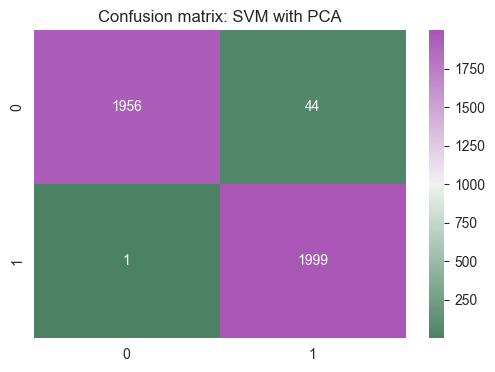

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('pca',
                  PCA(n_components=0.95, random_state=42, svd_solver='full')),
                 ('svm', SVC(probability=True, random_state=42))]),
 {'0': {'precision': 0.9994890137966275,
   'recall': 0.978,
   'f1-score': 0.9886277482941622,
   'support': 2000.0},
  '1': {'precision': 0.9784630445423397,
   'recall': 0.9995,
   'f1-score': 0.9888696512490724,
   'support': 2000.0},
  'accuracy': 0.98875,
  'macro avg': {'precision': 0.9889760291694836,
   'recall': 0.98875,
   'f1-score': 0.9887486997716173,
   'support': 4000.0},
  'weighted avg': {'precision': 0.9889760291694836,
   'recall': 0.98875,
   'f1-score': 0.9887486997716174,
   'support': 4000.0}},
 array([[1956,   44],
        [   1, 1999]], dtype=int64))

In [112]:
svm_pipe_pca = Pipeline([('scaler', StandardScaler()), 
                     ('pca', PCA(n_components=0.95,svd_solver='full', random_state=42)),
                         ('svm', SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42))])

cv_pca_svm = cross_val_score(svm_pipe_pca, X_train, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"SVM with PCA(0.95):     {cv_pca_svm.mean():.4f} ± {cv_pca_svm.std():.4f}")

evaluate_model(svm_pipe_pca, X_train, X_test, y_train, y_test, 'SVM with PCA')

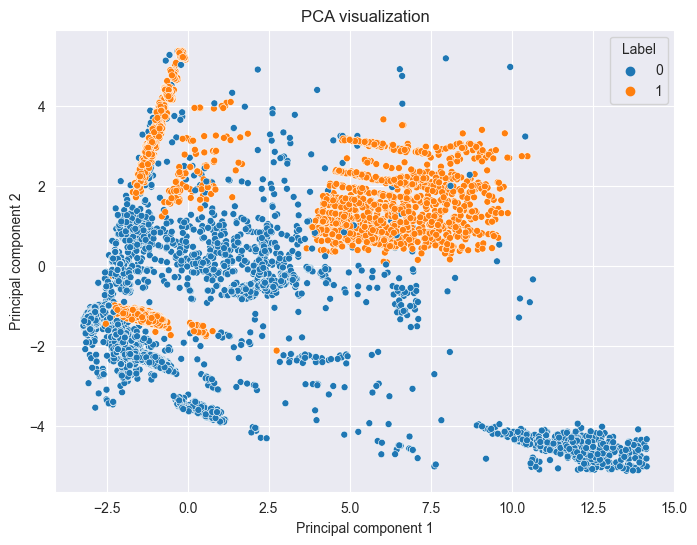

In [113]:
pca_vis_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42))
])

X_train_pca = pca_vis_pipe.fit_transform(X_train)

x = X_train_pca[:,0]
y = X_train_pca[:,1]

x_low, x_high = np.percentile(x, [1, 99])
y_low, y_high = np.percentile(y, [1, 99])

mask = (x >= x_low) & (x <= x_high) & (y >= y_low) & (y <= y_high)
plt.figure(figsize=(8,6))
sns.scatterplot(x=x[mask], y=y[mask], hue=y_train[mask], palette="tab10", s=25)
plt.title("PCA visualization")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.show()

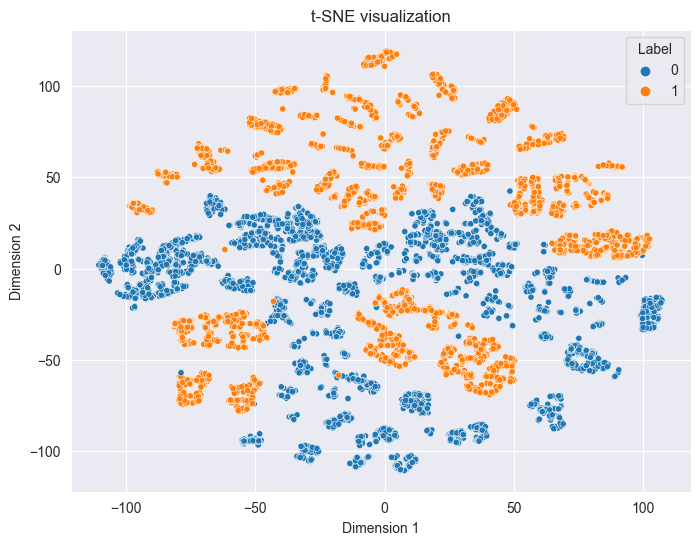

In [114]:
tsne_vis_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2, random_state=42, perplexity=30))
])

X_train_tsne = tsne_vis_pipe.fit_transform(X_train)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train, palette="tab10", s=20)
plt.title("t-SNE visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [115]:
img = io.imread("HD-wallpaper-cute-lovebirds-parrot-lovebirds-parrots-agapornis.jpg")
img = img / 255.0 

h, w, c = img.shape
print(f"Image shape: {img.shape}")

Image shape: (533, 800, 3)


In [116]:
pixels = img.reshape(-1, 3)
unique_colors = np.unique(pixels, axis=0)
print("Unique colors in the initial pic:", unique_colors.shape[0])

Unique colors in the initial pic: 146195


In [117]:
def quantize_image(pixels, n_colors):
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    return new_colors.reshape(h, w, 3)

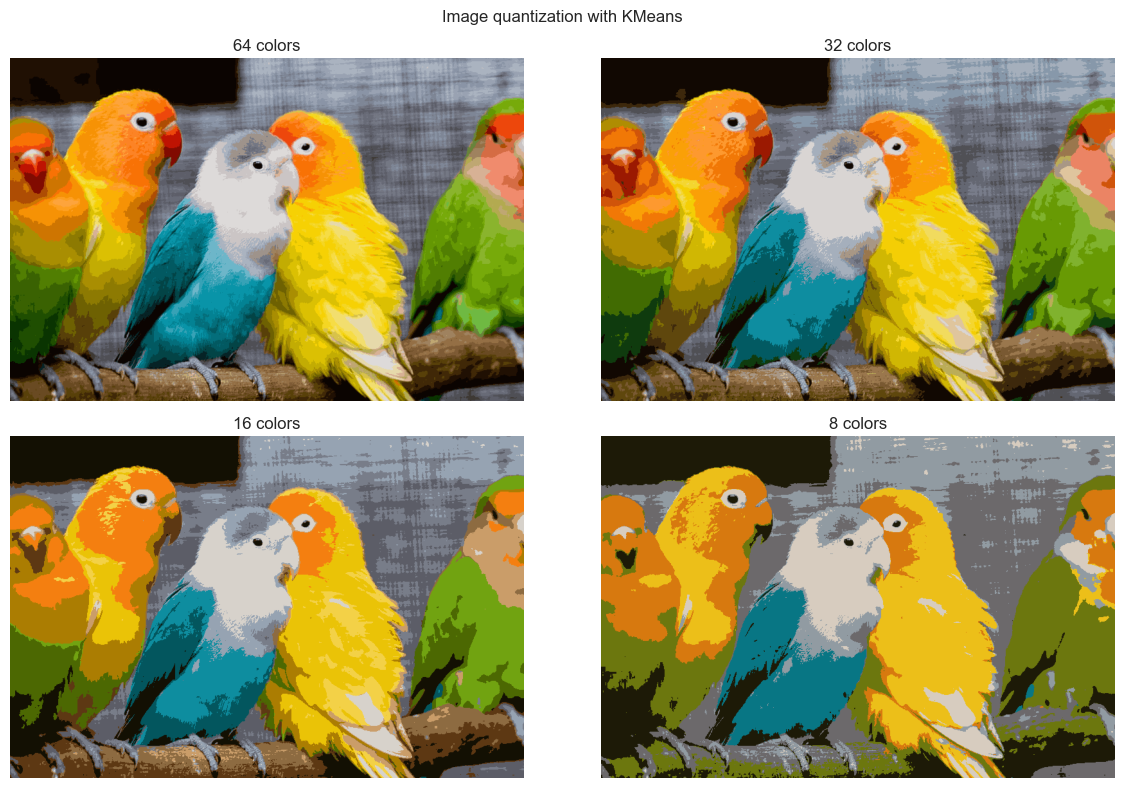

In [118]:
colors = [64, 32, 16, 8]

plt.figure(figsize=(12, 8))

for i, n_colors in enumerate(colors):
    quantized_img = quantize_image(pixels, n_colors)
    plt.subplot(2, 2, i+1)
    plt.imshow(quantized_img)
    plt.title(f"{n_colors} colors")
    plt.axis('off')

plt.suptitle("Image quantization with KMeans")
plt.tight_layout()
plt.show()

In [119]:
newsgroups = fetch_20newsgroups(subset='all', categories=['alt.atheism', 'sci.med', 'sci.electronics'],remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
labels = newsgroups.target
target_names = newsgroups.target_names

print(f"Documents amount: {len(texts)}")
print(f"Class amount: {len(target_names)}")
print("Classes:", target_names)

Documents amount: 2773
Class amount: 3
Classes: ['alt.atheism', 'sci.electronics', 'sci.med']


In [120]:
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

print(texts[0])
texts_cleaned = [clean_text(t) for t in texts]


And has been rather thoroughly demolished as myth by Robert Scott Root-
Bernstein.  See his book, "Discovering".  Ring structures for benzene
had been proposed before Kekule', after him, and at the same time as him.
The current models do not resemble Kekule's.  Many of the predecessors
of Kekule's structure resemble the modern model more.

I don't think "extra-scientific" is a very useful phrase in a discussion
of the boundaries of science, except as a proposed definiens.  Extra-rational
is a better phrase.  In fact, there are quite a number of well-known cases
of extra-rational considerations driving science in a useful direction.

For example, Pasteur discovered that racemic acid was a mixture of
enantiomers (the origin of stereochemistry) partly because he liked a
friend's crank theory of chemical action.  The friend was wrong, but
Pasteur's discovery stood.  A prior investigator (Mitscherlich), looking
at the same phenomenon, had missed a crucial detail; presumably because he
lack

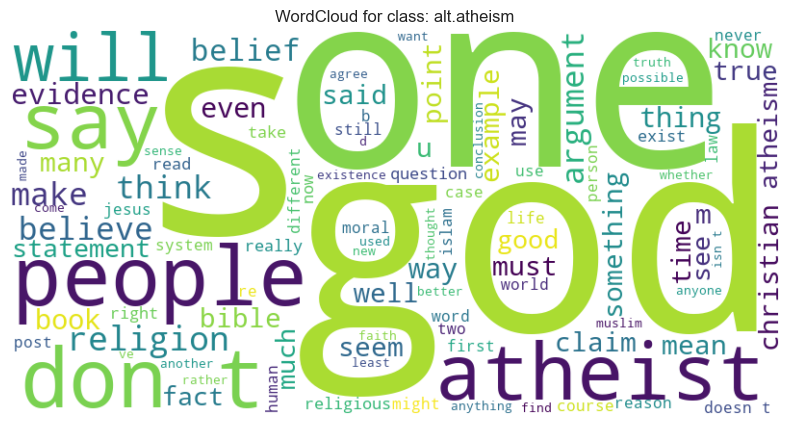

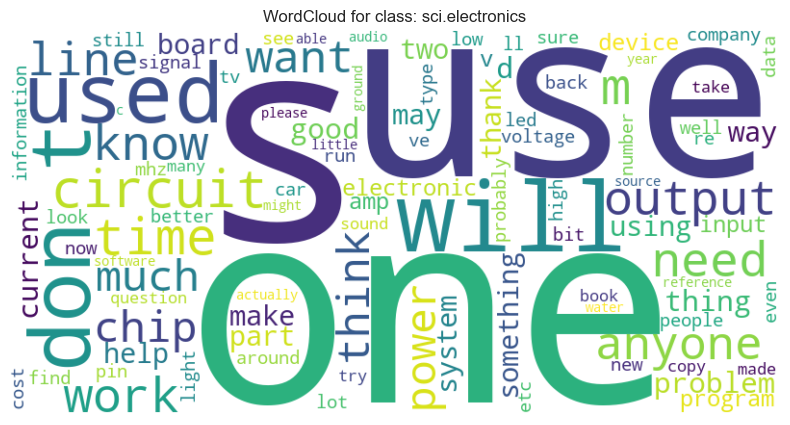

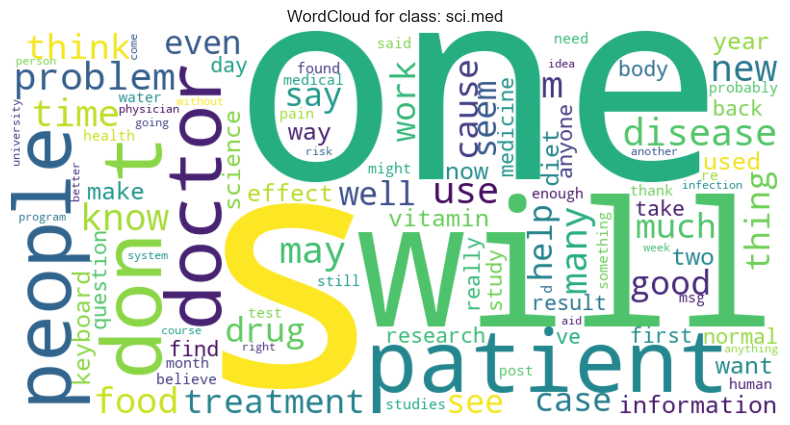

In [121]:
def plot_wordcloud_for_class(class_id):
    texts_in_class = [texts_cleaned[i] for i, lbl in enumerate(labels) if lbl == class_id]
    combined_text = " ".join(texts_in_class[:500])  
    wc = WordCloud(stopwords=STOPWORDS, max_words=100, background_color="white", width=800, height=400).generate(combined_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for class: {target_names[class_id]}")
    plt.show()


for class_id in [0, 1, 2]:
    plot_wordcloud_for_class(class_id)

In [122]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(texts_cleaned)

print("The feature matrix form:", X.shape)

The feature matrix form: (2773, 5000)


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42, stratify=labels)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2079, 5000) Test: (694, 5000)


In [124]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

=== Classification report ===
                 precision    recall  f1-score   support

    alt.atheism       0.93      0.85      0.89       200
sci.electronics       0.92      0.92      0.92       246
        sci.med       0.86      0.91      0.89       248

       accuracy                           0.90       694
      macro avg       0.90      0.90      0.90       694
   weighted avg       0.90      0.90      0.90       694



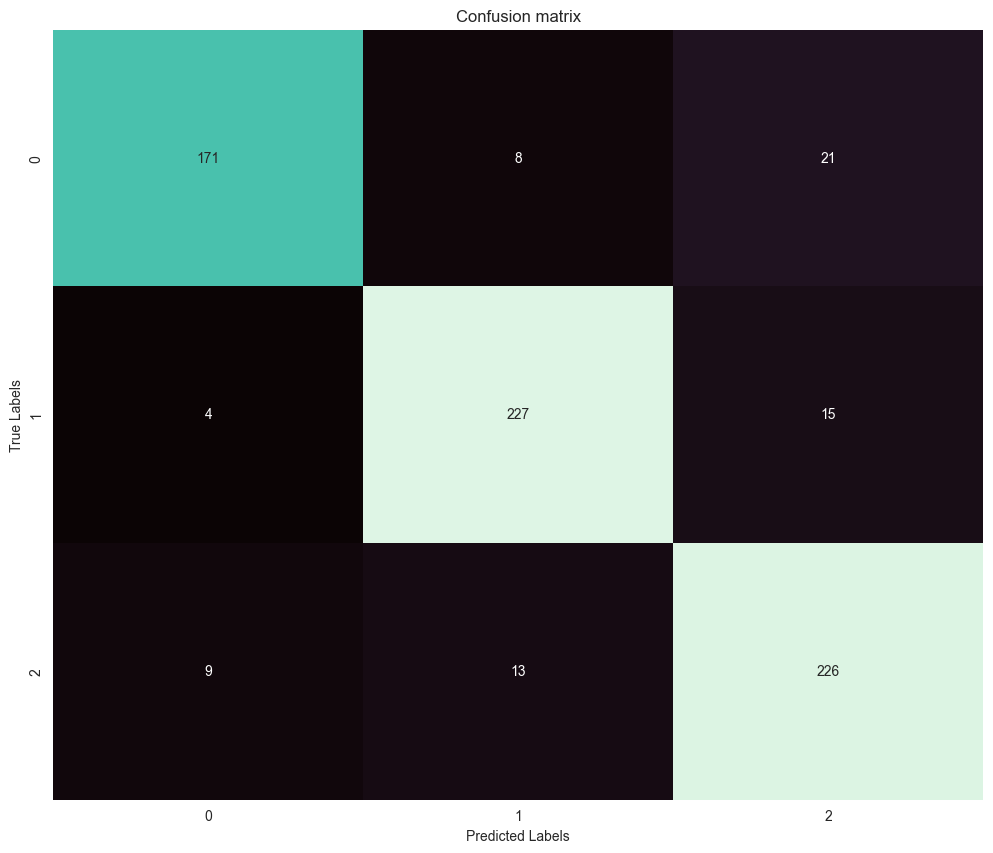

In [125]:
print("=== Classification report ===")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="mako", cbar=False, annot=True, fmt="d")

plt.title("Confusion matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
